In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import math
from scipy import stats
from sklearn.preprocessing import StandardScaler

def plot(function, columns, data, x='col', y='none', hue=None):
    fig, axs = plt.subplots(1, len(columns), figsize=(20, 7))
    i = 0
    for col in columns:
        if x=='col':
            g = function(data=data, x=col, ax=axs[i], hue=hue, multiple='dodge', shrink=0.9)
        elif y=='col':
            g= function(data=data, y=col, x=x, ax=axs[i], hue=hue)
        i+=1
        if (function==sns.histplot):
            temp = data[columns]
            if hue is None:
                y_lim =  temp.apply(pd.value_counts).max().max()*1.05
            else:
                y_lim = temp.groupby(hue).count().max().max()*1.05
            g.set(ylim=(0,y_lim))
    plt.subplots_adjust(hspace = 0.5, wspace=0.5)
    plt.show()


In [2]:
df = pd.read_csv('heart.csv').set_index('HeartDisease').reset_index().rename(columns={'FastingBS':'FastingBS_120+'})
df.head()

,HeartDisease,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS_120+,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up
1,1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat
2,0,37,M,ATA,130,283,0,ST,98,N,0.0,Up
3,1,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat
4,0,54,M,NAP,150,195,0,Normal,122,N,0.0,Up


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HeartDisease    918 non-null    int64  
 1   Age             918 non-null    int64  
 2   Sex             918 non-null    object 
 3   ChestPainType   918 non-null    object 
 4   RestingBP       918 non-null    int64  
 5   Cholesterol     918 non-null    int64  
 6   FastingBS_120+  918 non-null    int64  
 7   RestingECG      918 non-null    object 
 8   MaxHR           918 non-null    int64  
 9   ExerciseAngina  918 non-null    object 
 10  Oldpeak         918 non-null    float64
 11  ST_Slope        918 non-null    object 
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


# CATEGORICAL FEATURES HISTOGRAM

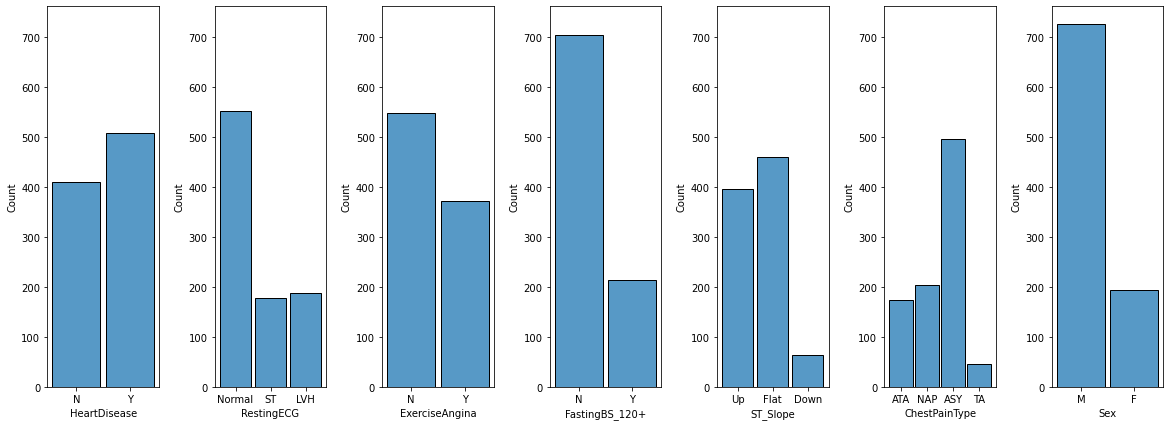

In [4]:
# Categorical columns (non-numeric OR only 2 values)
ohe_cols = (df.dtypes=='object')
ohe_cols = ohe_cols[ohe_cols].index.tolist()
bin_cols = (df.nunique()==2)
bin_cols = bin_cols[bin_cols].index.tolist()

plot(sns.histplot, set(ohe_cols+bin_cols+['HeartDisease']), df.replace({0: 'N', 1:'Y'}))#, hue='HeartDisease')

Sex and FastingBS_120+ are clearly imbalanced.

Certain others seem somewhat imbalaced:
- RestingECG (Normal $\approx$ ST + LVH)
- ST_Slope (Down largly under-represented)
- ChestPainType (TA largly under-represented)

In [5]:
df

,HeartDisease,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS_120+,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up
1,1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat
2,0,37,M,ATA,130,283,0,ST,98,N,0.0,Up
3,1,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat
4,0,54,M,NAP,150,195,0,Normal,122,N,0.0,Up
...,...,...,...,...,...,...,...,...,...,...,...,...
913,1,45,M,TA,110,264,0,Normal,132,N,1.2,Flat
914,1,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat
915,1,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat
916,1,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat


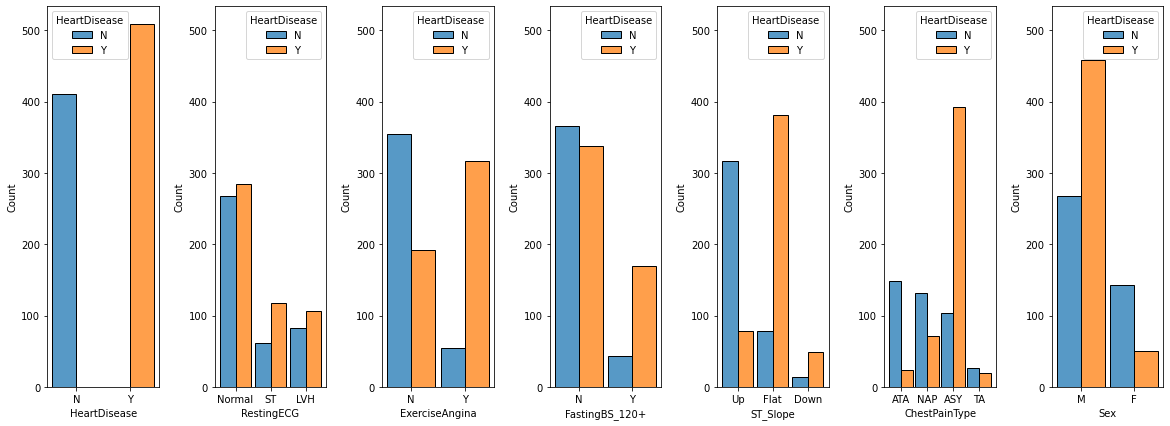

In [6]:
plot(sns.histplot, set(ohe_cols+bin_cols), df.replace({0: 'N', 1:'Y'}), hue='HeartDisease')

# CONTINUOUS FEATURES BOXPLOT

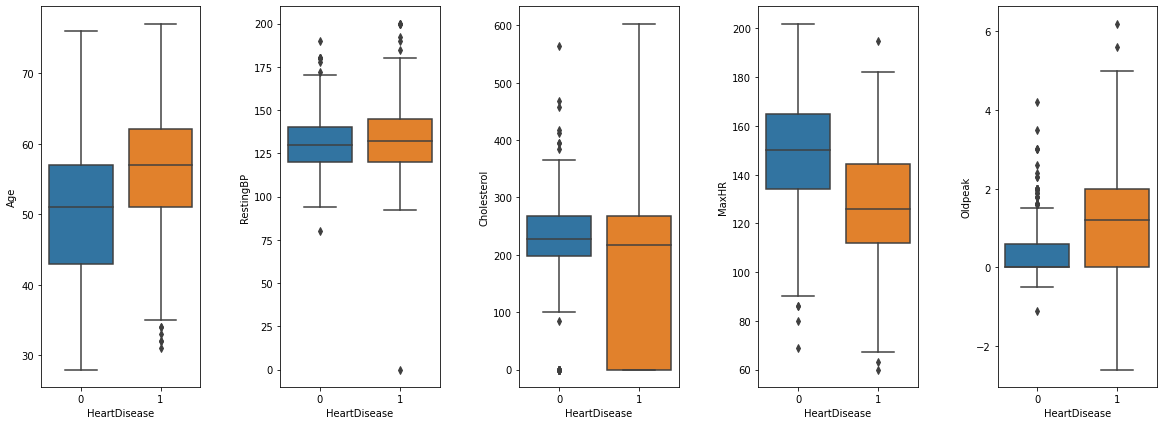

In [7]:
non_bin =df.drop(columns=ohe_cols+bin_cols)
selection = non_bin.columns.tolist()

plot(sns.boxplot, selection, df, x='HeartDisease', y='col')

# PREPARE DATASET: 
1. OHE and Binary to (0, 1):
    - Sex (M or F), ExerciseAngine (N or Y), FastingBS_120+ (0 or 1) are binary -> 0, 1
    - ChestPainType, ST_Slope and RestingECG are categorical -> One Hot Encoding
2. Standardize continuous columns
    - Age, RestingBP, Cholesterol, MaxHR, OldPeak

In [8]:
prepared = df.copy(deep=True)

bin_cols = ['Sex', 'ExerciseAngina', 'FastingBS_120+']
prepared[bin_cols] = prepared[bin_cols].replace({'M':0, 'F':1, 'N' : 0, 'Y':1})

ohe_cols = ['ChestPainType','ST_Slope', 'RestingECG']
prepared = pd.get_dummies(prepared, columns=ohe_cols)

continuous_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
prepared[continuous_cols] = StandardScaler().fit_transform(df[continuous_cols])

In [9]:
prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   HeartDisease       918 non-null    int64  
 1   Age                918 non-null    float64
 2   Sex                918 non-null    int64  
 3   RestingBP          918 non-null    float64
 4   Cholesterol        918 non-null    float64
 5   FastingBS_120+     918 non-null    int64  
 6   MaxHR              918 non-null    float64
 7   ExerciseAngina     918 non-null    int64  
 8   Oldpeak            918 non-null    float64
 9   ChestPainType_ASY  918 non-null    uint8  
 10  ChestPainType_ATA  918 non-null    uint8  
 11  ChestPainType_NAP  918 non-null    uint8  
 12  ChestPainType_TA   918 non-null    uint8  
 13  ST_Slope_Down      918 non-null    uint8  
 14  ST_Slope_Flat      918 non-null    uint8  
 15  ST_Slope_Up        918 non-null    uint8  
 16  RestingECG_LVH     918 non

# Testing

### 2 Tailed T-Test:
- Compare population means
- Assume no equal variances between population (look into this)
- $H_{0}$ : $\mu_{i, heartdisease} = \mu_{i, no\_heartdisease}$
- $H_{a}$ : $\mu_{i, heartdisease} \neq \mu_{i, no\_heartdisease}$  
where i $\in$ ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [10]:
significantly_different = []

def ind_t_test(column, group, data):

    group0 = data[data[group]==0][column]
    group1 = data[data[group]==1][column]
    
    print(column,':')
    t_stat, p_val = stats.ttest_ind(group0, group1, equal_var=False)
    reject = p_val<significance_level
    print('\t-{} {} vs {} {} => p-value: {:.2E}, t statistic: {:.5f}'.format(group, 0, group, 1, p_val, t_stat))
    if reject:
        print('\t {:.2E} {} {}. H0 is {}. Both populations are {} significantly different'.format(p_val, '<', significance_level, 'rejected', ''))
    else:
        print('\t {:.2E} {} {}. H0 is {}. Both populations are {} significantly different.'.format(p_val, '>', significance_level, 'accepted', 'not'))
    print()
    return reject

significance_level = 0.05
for col in continuous_cols:
    if(ind_t_test(col, 'HeartDisease', prepared)):
        significantly_different.append(col)

Age :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 6.35E-18, t statistic: -8.82254
	 6.35E-18 < 0.05. H0 is rejected. Both populations are  significantly different

RestingBP :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 8.73E-04, t statistic: -3.33949
	 8.73E-04 < 0.05. H0 is rejected. Both populations are  significantly different

Cholesterol :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 6.48E-14, t statistic: 7.62685
	 6.48E-14 < 0.05. H0 is rejected. Both populations are  significantly different

MaxHR :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 1.43E-36, t statistic: 13.23148
	 1.43E-36 < 0.05. H0 is rejected. Both populations are  significantly different

Oldpeak :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 1.90E-40, t statistic: -14.04003
	 1.90E-40 < 0.05. H0 is rejected. Both populations are  significantly different



### Chi-Squared tests:
- Compare heart disease proportions between populations
- $H_0$: i is indepent to HeartDisease
- $H_a$: i is depent to HeartDisease  
where i $\in$ ['Sex', 'FastingBS_120+', 'ExerciseAngina', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST']


In [11]:
def ind_chi2_test(column, group, data):
    contigency = pd.crosstab(prepared[col], prepared[group])
    chi2, p_val, dof, expected = stats.chi2_contingency(contigency) 
    reject = p_val<significance_level
    
    print(column,':')
    print('\t-{} {} vs {} {} => p-value: {:.2E}, Chi-Square value: {:.5f}'.format(group, data[group].unique()[0], group, data[group].unique()[0], p_val, chi2))
    if reject:
        print('\t {:.2E} {} {}. H0 is {}. Both populations are {} significantly different'.format(p_val, '<', significance_level, 'rejected', ''))
    else:
        print('\t {:.2E} {} {}. H0 is {}. Both populations are {} significantly different.'.format(p_val, '>', significance_level, 'accepted', 'not'))
    print()
    return reject

significance_level = 0.05
for col in prepared.drop(columns=continuous_cols+['HeartDisease']):
    if(ind_chi2_test(col, 'HeartDisease', prepared)):
        significantly_different.append(col)

Sex :
	-HeartDisease 0 vs HeartDisease 0 => p-value: 4.60E-20, Chi-Square value: 84.14510
	 4.60E-20 < 0.05. H0 is rejected. Both populations are  significantly different

FastingBS_120+ :
	-HeartDisease 0 vs HeartDisease 0 => p-value: 1.06E-15, Chi-Square value: 64.32068
	 1.06E-15 < 0.05. H0 is rejected. Both populations are  significantly different

ExerciseAngina :
	-HeartDisease 0 vs HeartDisease 0 => p-value: 2.91E-50, Chi-Square value: 222.25938
	 2.91E-50 < 0.05. H0 is rejected. Both populations are  significantly different

ChestPainType_ASY :
	-HeartDisease 0 vs HeartDisease 0 => p-value: 8.63E-55, Chi-Square value: 243.02114
	 8.63E-55 < 0.05. H0 is rejected. Both populations are  significantly different

ChestPainType_ATA :
	-HeartDisease 0 vs HeartDisease 0 => p-value: 1.15E-33, Chi-Square value: 146.23632
	 1.15E-33 < 0.05. H0 is rejected. Both populations are  significantly different

ChestPainType_NAP :
	-HeartDisease 0 vs HeartDisease 0 => p-value: 1.86E-10, Chi-Square

In [12]:
significantly_different

['Age',
 'RestingBP',
 'Cholesterol',
 'MaxHR',
 'Oldpeak',
 'Sex',
 'FastingBS_120+',
 'ExerciseAngina',
 'ChestPainType_ASY',
 'ChestPainType_ATA',
 'ChestPainType_NAP',
 'ST_Slope_Down',
 'ST_Slope_Flat',
 'ST_Slope_Up',
 'RestingECG_Normal',
 'RestingECG_ST']

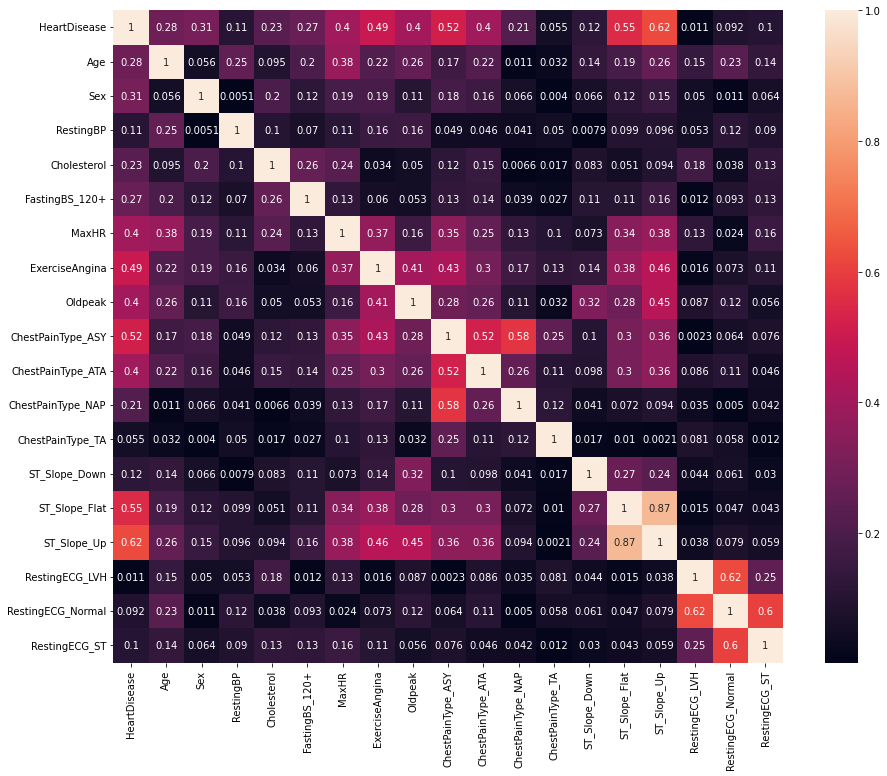

In [13]:
plt.figure(figsize=(15, 12))
sns.heatmap(prepared.corr().abs(),  annot=True)
plt.show()